In [6]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [7]:
import warnings
warnings.filterwarnings("ignore")

import glob
import shutil
import itertools
import os
import sys
import importlib  

import pickle

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import random

from sklearn.utils import resample, shuffle

import six
import sys
sys.modules['sklearn.externals.six'] = six

import sklearn.neighbors._base
sys.modules['sklearn.neighbors.base'] = sklearn.neighbors._base

from sklearn.utils import _safe_indexing
sys.modules['sklearn.utils.safe_indexing'] = _safe_indexing

from localfinlab.clustering import *

import localfinlab as lfl
from localfinlab.utils import flatten, postfix_keys_to_dict, get_current_time_hash, get_random_hash


In [12]:
# a0ffcabf03d9c1320e60b09556b7dd0a_ae.csv - 2012 - 30
# fin_bf672f94b8548e9bb32e9a6a20463a07_ae.csv - 2013 - 30
# 38d975761f1e86d3b2002e92d2f83f7b_ae_.csv - 2014 - 30
# backtest_results_ae_df = pd.read_csv('./backtest_results/38d975761f1e86d3b2002e92d2f83f7b_ae_.csv')

# af6ebf5a064c26181583dd53195b9cf4.csv - 2012 - 38
# da294a6e57c7f5315d5b7026955becf6.csv - 2013 - 38
# 002a0d2dbde527ab7fb1c3fb56069dd9.csv - 2014 - 46
# backtest_results_df = pd.read_csv('./002a0d2dbde527ab7fb1c3fb56069dd9.csv')


In [4]:

from localfinlab.pairs_trading_backtester import (
    Trader
)

def get_merged_analytics_as_dataframe(file_list, filter_results=True):

    results_per_period = []

    for file in file_list:
        backtest_results_ae_df = pd.read_csv(file['filepath'])

        working_example_df_ae = backtest_results_ae_df[backtest_results_ae_df['clust_algo'] == file['clust_algo']]
        
        if filter_results:
            working_example_df_ae = working_example_df_ae[working_example_df_ae['distance_measure'] == file['distance_measure']] #54 #70
            working_example_df_ae = working_example_df_ae[working_example_df_ae['n_clusters'] == file['n_clusters']] #54 #70

        results_per_period.append(working_example_df_ae)

    return pd.concat(results_per_period)

ae_file_list = [{'filepath':'./backtest_results/a0ffcabf03d9c1320e60b09556b7dd0a_ae.csv', 'clust_algo': 'kmeans', 'distance_measure': 'euclidean', 'n_clusters': 30}, 
             {'filepath':'./backtest_results/fin_bf672f94b8548e9bb32e9a6a20463a07_ae.csv', 'clust_algo': 'kmeans', 'distance_measure': 'euclidean', 'n_clusters': 30}, 
             {'filepath':'./backtest_results/38d975761f1e86d3b2002e92d2f83f7b_ae_.csv', 'clust_algo': 'kmeans', 'distance_measure': 'euclidean', 'n_clusters': 30}]


pca_file_list = [{'filepath': './af6ebf5a064c26181583dd53195b9cf4.csv', 'clust_algo': 'kmeans', 'distance_measure': 'euclidean', 'n_clusters':34}, 
             {'filepath': './da294a6e57c7f5315d5b7026955becf6.csv', 'clust_algo': 'kmeans', 'distance_measure': 'euclidean', 'n_clusters':46}, 
             {'filepath': './002a0d2dbde527ab7fb1c3fb56069dd9.csv', 'clust_algo': 'kmeans', 'distance_measure': 'euclidean', 'n_clusters':46}]

def get_merged_results_as_dataframe(file_list):

    results_per_period = []

    for file in file_list:
        backtest_results_ae_df = pd.read_csv(meta_data_files[file['split_idx']])

        working_example_df_ae = backtest_results_ae_df[backtest_results_ae_df['clust_algo'] == file['clust_algo']]
        working_example_df_ae = working_example_df_ae[working_example_df_ae['distance_measure'] == file['distance_measure']]
        working_example_df_ae = working_example_df_ae[working_example_df_ae['n_clusters'] == file['n_clusters']]

        results_per_period.append(working_example_df_ae)

    merged_results = []

    for period_zero_sample in results_per_period[0].iterrows():
    #     find equivalent from results_per_period[1]

        working_period_one_df_ae = results_per_period[1].dropna()
        working_period_one_df_ae = working_period_one_df_ae[working_period_one_df_ae['seed'] == period_zero_sample[1]['seed']]

        if len(working_period_one_df_ae) != 0:
            working_period_one_df_ae = working_period_one_df_ae.dropna().sample(1)
        else: 
            working_period_one_df_ae = results_per_period[1].dropna().sample(1)

    #     find equivalent from results_per_period[2]

        working_period_two_df_ae = results_per_period[2].dropna()
        working_period_two_df_ae = working_period_two_df_ae[working_period_two_df_ae['seed'] == period_zero_sample[1]['seed']].dropna()

        if len(working_period_two_df_ae) != 0:
            working_period_two_df_ae = working_period_two_df_ae.dropna().sample(1)
        else: 
            working_period_two_df_ae = results_per_period[2].dropna().sample(1)

        merged_results.append([period_zero_sample[1]['clust_algo'], period_zero_sample[1]['seed'],

                               period_zero_sample[1]['portfolio_returns_saved_file_insample'], 
                               period_zero_sample[1]['portfolio_returns_saved_file_oosample'],

                               working_period_one_df_ae['portfolio_returns_saved_file_insample'].values[0], 
                               working_period_one_df_ae['portfolio_returns_saved_file_oosample'].values[0],

                               working_period_two_df_ae['portfolio_returns_saved_file_insample'].values[0], 
                               working_period_two_df_ae['portfolio_returns_saved_file_oosample'].values[0],
                              ])

    merged_results_df = pd.DataFrame(merged_results, columns=['clust_algo', 'rand_seed', 
                           'period_zero_returns_file_insample', 'period_zero_returns_file_oosample',
                           'period_one_returns_file_insample', 'period_one_returns_file_oosample',
                           'period_two_returns_file_insample', 'period_two_returns_file_oosample',
                          ])

    return merged_results_df

def sample_n_times(N, file_list):
    sampled_dfs = []
    
    for _ in range(N):
        sample_df = get_merged_results_as_dataframe(file_list)
        sampled_dfs.append(sample_df)
        
    return pd.concat(sampled_dfs)

def get_collated_returns_as_dataframe(merged_results_df, sample_period='oosample'):
    collated_dfs = []

    for full_period_sample in merged_results_df.iterrows():
        per_zero = pd.read_csv('./backtest_results/return_series/' + full_period_sample[1]['period_zero_returns_file_' + sample_period])
        per_one = pd.read_csv('./backtest_results/return_series/' + full_period_sample[1]['period_one_returns_file_' + sample_period])
        per_two = pd.read_csv('./backtest_results/return_series/' + full_period_sample[1]['period_two_returns_file_' + sample_period])

        collated_df = pd.concat([per_zero, per_one, per_two])
        collated_df['Date'] = pd.to_datetime(collated_df['Date'])
        collated_df.set_index('Date', inplace=True, drop=True)

        collated_dfs.append(collated_df)
        
    return collated_dfs


def get_sharpe_distribution_from_collated_returns(collated_dfs, rf_rate=0.01):
    
    annualized_ret = pd.concat(collated_dfs, axis=1).mean()*252
    vol = pd.concat(collated_dfs, axis=1).std()*np.sqrt(252)

    rf_daily = (1+rf_rate)**(1/252)-1

    sharpe_ratio_assuming_iid = (annualized_ret-rf_daily) /vol
    
    return sharpe_ratio_assuming_iid


def get_mdd_distribution_from_collated_returns(collated_dfs, rf_rate=0.01):
    trader_obj = Trader()
    
    cum_rets = pd.concat(collated_dfs, axis=1).cumsum()

    mdd_dist = []
    for cr in range(len(cum_rets.columns)):
        mdd_dist.append( trader_obj.calculate_maximum_drawdown(1+cum_rets.iloc[:, cr]*1, False)[0] )
    
    return np.array(mdd_dist)

/home/aaron/.local/lib/python3.8/site-packages/numba/core/errors.py:175: UserWarning: Insufficiently recent colorama version found. Numba requires colorama >= 0.3.9
  warnings.warn(msg)
/home/aaron/.local/lib/python3.8/site-packages/dash_bootstrap_components/_table.py:1: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  import dash_html_components as html
/home/aaron/Apprenticeship/mlfinlab_premium/mlfinlab/networks/dash_graph.py:18: UserWarning: 
The dash_core_components package is deprecated. Please replace
`import dash_core_components as dcc` with `from dash import dcc`
  import dash_core_components as dcc


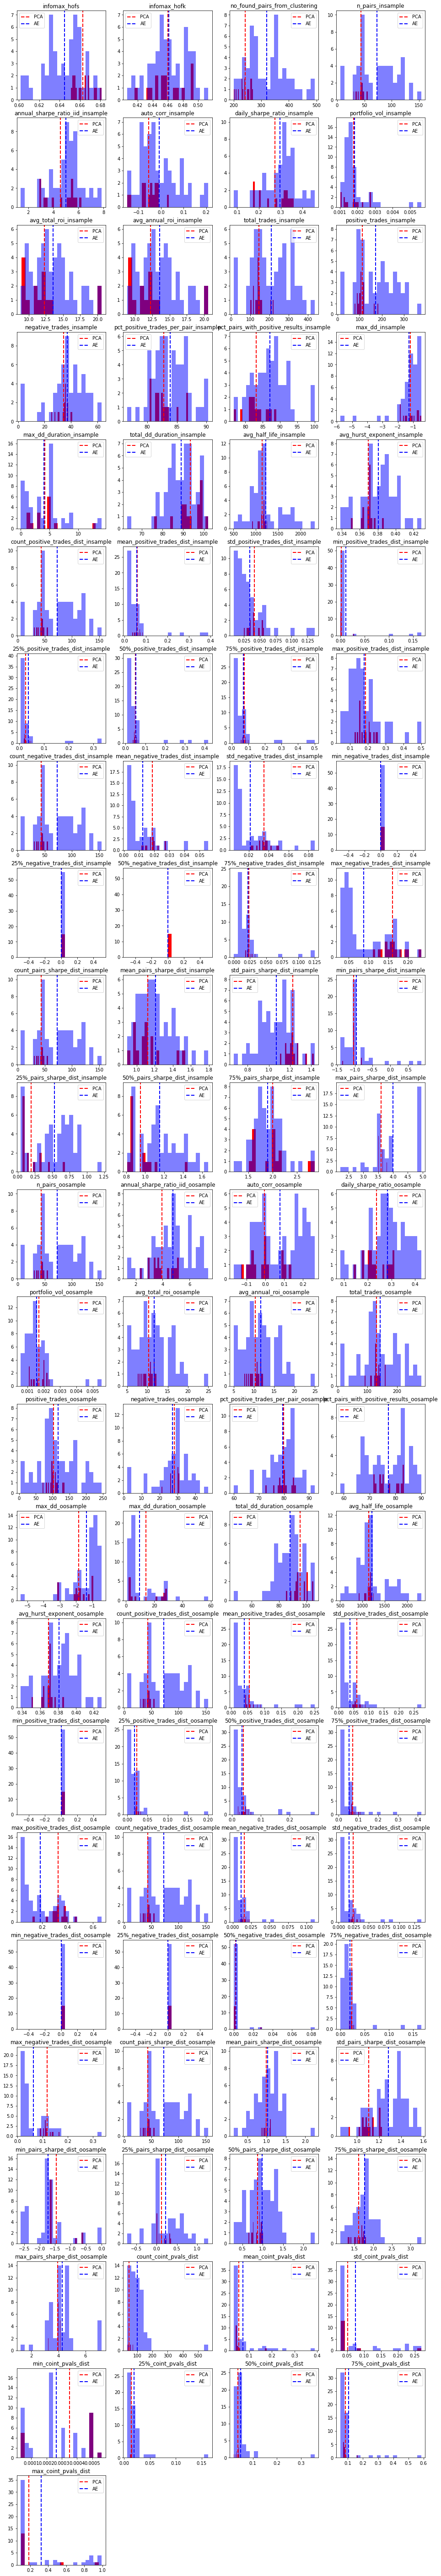

In [7]:

analytics_df = get_merged_analytics_as_dataframe(ae_file_list + pca_file_list).iloc[:, 1:]

columns_to_ignore = ['train_period_start', 'train_period_end', 'test_period_start',
                     'test_period_end', 'validation_period', 'n_clusters',
                     'pvalue_threshold', 'seed', 'clust_algo', 'explained_variance',
                     'hurst_threshold', 'distance_measure',
                     'min_zero_crossings', 'qvalue_threshold',
                     'multiple_hypothesis_correction_method', 'avg_hurst_exponent_oosample'
                     'n_clusters', 'n_principal_components', 'portfolio_returns_saved_file_insample', 
                     'portfolio_returns_saved_file_oosample']

working_analytics_df = analytics_df.loc[:, ~analytics_df.columns.isin(columns_to_ignore)]

colors = ['r', 'b']
plt.figure(figsize=(16, 120))
for idx, col in enumerate(working_analytics_df.columns[:-1]):
    plt.subplot(28, 4, idx + 1)
    for ic, dim_method in enumerate(['PCA', 'AutoEncoder']): # 'dimensionality_reduction_method'
        label_mask = working_analytics_df[working_analytics_df['dimensionality_reduction_method'] == dim_method].dropna().reset_index().index
        qlow = working_analytics_df.iloc[label_mask, idx].quantile(0.01)
        qhigh = working_analytics_df.iloc[label_mask, idx].quantile(0.99)
        plt.hist(working_analytics_df.iloc[label_mask, idx],
#                  .clip(lower=qlow, upper=qhigh),
#                  .replace(qlow, np.nan)
#                  .replace(qhigh, np.nan),
                 bins=20, 
                 log=False, 
                 color=colors[ic], 
                 alpha=0.5 if dim_method == 'AutoEncoder' else 1)
        plt.axvline(x=working_analytics_df.iloc[label_mask, idx].mean(), color=colors[ic],
                    linestyle='dashed', linewidth=2)
    plt.title(col)
    plt.legend(['PCA', 'AE'])
plt.show()


In [9]:
merged_results_pca_df = sample_n_times(4, pca_file_list)
merged_results_ae_df = sample_n_times(3, ae_file_list) 

KeyError: 'split_idx'

In [32]:
pca_returns_collated_df = get_collated_returns_as_dataframe(merged_results_pca_df)
ae_returns_collated_df = get_collated_returns_as_dataframe(merged_results_ae_df)

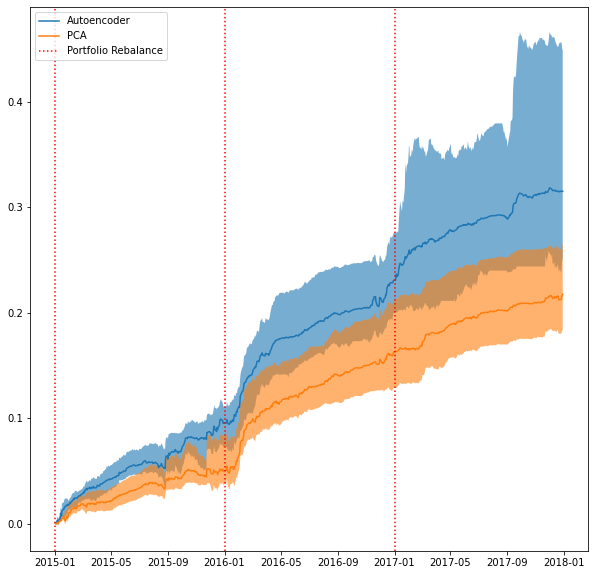

In [117]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10));

ae_returns_cumsum_collated = pd.concat(ae_returns_collated_df, axis=1)
ae_returns_cumsum_collated.index = pd.to_datetime(ae_returns_cumsum_collated.index)

ae_returns_cumsum_collated_mean = ae_returns_cumsum_collated.mean(axis=1).cumsum()
ae_returns_cumsum_collated_max = ae_returns_cumsum_collated.cumsum().max(axis=1)
ae_returns_cumsum_collated_min = ae_returns_cumsum_collated.cumsum().min(axis=1)

ax.plot(ae_returns_cumsum_collated_mean, label='Autoencoder')
ax.fill_between(ae_returns_cumsum_collated_mean.index, ae_returns_cumsum_collated_max, ae_returns_cumsum_collated_min, alpha=0.6);

pca_returns_cumsum_collated = pd.concat(pca_returns_collated_df, axis=1)
pca_returns_cumsum_collated.index = pd.to_datetime(pca_returns_cumsum_collated.index)

pca_returns_cumsum_collated_mean = pca_returns_cumsum_collated.mean(axis=1).cumsum()
pca_returns_cumsum_collated_max = pca_returns_cumsum_collated.cumsum().max(axis=1)
pca_returns_cumsum_collated_min = pca_returns_cumsum_collated.cumsum().min(axis=1)

ax.plot(pca_returns_cumsum_collated_mean, label='PCA')
ax.fill_between(pca_returns_cumsum_collated_mean.index, pca_returns_cumsum_collated_max, pca_returns_cumsum_collated_min, alpha=0.6);

ax.axvline(x=pd.to_datetime('2015-01'), linestyle=':', c='r', label='Portfolio Rebalance')
ax.axvline(x=pd.to_datetime('2016-01'), linestyle=':', c='r')
ax.axvline(x=pd.to_datetime('2017-01'), linestyle=':', c='r')

plt.legend(loc="upper left");



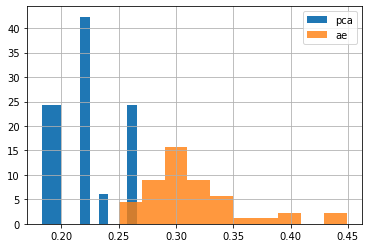

In [91]:
pca_cumrets_results = pd.concat(pca_returns_collated_df, axis=1).cumsum().iloc[-1]
ae_cumrets_results = pd.concat(ae_returns_collated_df, axis=1).cumsum().iloc[-1]

pca_cumrets_results.hist(label='pca', density=True)
ae_cumrets_results.hist(label='ae', alpha=0.8, density=True)
plt.legend()

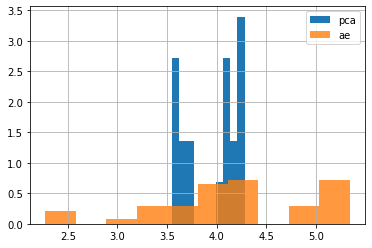

In [92]:
pca_sharpe_results = get_sharpe_distribution_from_collated_returns(pca_returns_collated_df)
ae_sharpe_results = get_sharpe_distribution_from_collated_returns(ae_returns_collated_df)

pca_sharpe_results.hist(label='pca', density=True)
ae_sharpe_results.hist(label='ae', alpha=0.8, density=True)
plt.legend()

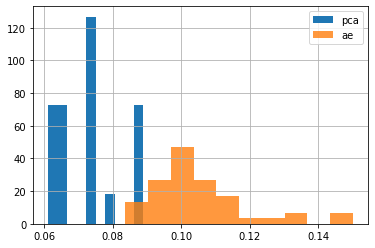

In [93]:
pca_rets_results = pd.concat(pca_returns_collated_df, axis=1).mean()*252
ae_rets_results = pd.concat(ae_returns_collated_df, axis=1).mean()*252

pca_rets_results.hist(label='pca', density=True)
ae_rets_results.hist(label='ae', alpha=0.8, density=True)
plt.legend()

In [18]:
stats.shapiro(pca_rets_results), stats.shapiro(ae_rets_results)


(ShapiroResult(statistic=0.8779668211936951, pvalue=0.01626703329384327),
 ShapiroResult(statistic=0.7390771508216858, pvalue=1.3824738687162608e-07))

In [19]:
from scipy import stats
rng = np.random.default_rng()

pca_vals = pca_rets_results.values

stats.ttest_rel(pca_rets_results.values, 
                pd.Series(ae_rets_results).sample(len(pca_vals)))

Ttest_relResult(statistic=-9.887385783406575, pvalue=6.31437096128916e-09)

In [20]:
stats.ttest_ind(pca_rets_results.values, 
                pd.Series(ae_rets_results).sample(len(pca_vals)), equal_var=False)

Ttest_indResult(statistic=-10.136727875909658, pvalue=2.7446193309688813e-12)